In [1]:
# SIMULATED DATA EXPERIMENTS
# RUN WITH python run_sim_experiments_dfNGP.py
# 
#       ooooooooooooooooooooooooooooooooooooo
#      8                                .d88
#      8  oooooooooooooooooooooooooooood8888
#      8  8888888888888888888888888P"   8888    oooooooooooooooo
#      8  8888888888888888888888P"      8888    8              8
#      8  8888888888888888888P"         8888    8             d8
#      8  8888888888888888P"            8888    8            d88
#      8  8888888888888P"               8888    8           d888
#      8  8888888888P"                  8888    8          d8888
#      8  8888888P"                     8888    8         d88888
#      8  8888P"                        8888    8        d888888
#      8  8888oooooooooooooooooooooocgmm8888    8       d8888888
#      8 .od88888888888888888888888888888888    8      d88888888
#      8888888888888888888888888888888888888    8     d888888888
#                                               8    d8888888888
#         ooooooooooooooooooooooooooooooo       8   d88888888888
#        d                       ...oood8b      8  d888888888888
#       d              ...oood888888888888b     8 d8888888888888
#      d     ...oood88888888888888888888888b    8d88888888888888
#     dood8888888888888888888888888888888888b
#
#
# This artwork is a visual reminder that this script is for the sim experiments.

model_name = "dfNGP"

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY
# also import x_test grid size and std noise for training data
from configs import N_SIDE, STD_GAUSSIAN_NOISE

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
NUM_RUNS = 1
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_SIM_LEARNING_RATE")
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")
import os
os.makedirs(MODEL_SIM_RESULTS_DIR, exist_ok = True)

# imports for probabilistic models
if model_name in ["GP", "dfGP", "dfNGP"]:
    from GP_models import GP_predict
    from metrics import compute_NLL_sparse, compute_NLL_full
    from configs import L_RANGE, SIGMA_N_RANGE, GP_PATIENCE
    # overwrite with GP_PATIENCE
    PATIENCE = GP_PATIENCE
    if model_name == "dfGP":
        from configs import SIGMA_F_RANGE
    if model_name == "dfNGP":
        # NOTE: This reflects that we have a mean model and sigma f for the residuals is smaller
        from configs import SIGMA_F_RESIDUAL_MODEL_RANGE

# for all models with NN components train on batches
if model_name in ["dfNGP", "dfNN", "PINN"]:
    from configs import BATCH_SIZE

if model_name in ["dfNGP", "dfNN"]:
    from NN_models import dfNN

# universals 
from metrics import compute_RMSE, compute_MAE, compute_divergence_field

# basics
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from codecarbon import EmissionsTracker

# utilitarian
from utils import set_seed, make_grid
# reproducibility
set_seed(42)
import gc

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

### START TRACKING EXPERIMENT EMISSIONS ###
tracker = EmissionsTracker(project_name = "dfNGP_simulation_experiments", output_dir = MODEL_SIM_RESULTS_DIR)
tracker.start()

### SIMULATION ###
# Import all simulation functions
from simulate import (
    simulate_detailed_branching,
    # simulate_detailed_convergence,
    simulate_detailed_curve,
    simulate_detailed_deflection,
    simulate_detailed_edge,
    simulate_detailed_ridges,
)

# Define simulations as a dictionary with names as keys to function objects
# alphabectic order here
simulations = {
    "branching": simulate_detailed_branching,
}

########################
### x_train & x_test ###
########################

# Load training inputs (once for all simulations)
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Generate x_test (long) once for all simulations
_, x_test = make_grid(N_SIDE)
# x_test is long format (N_SIDE ** 2, 2)

#################################
### LOOP 1 - over SIMULATIONS ###
#################################

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    ########################
    ### y_train & y_test ###
    ########################

    # Generate training observations
    # NOTE: sim_func() needs to be on CPU, so we move x_train to CPU
    y_train = sim_func(x_train.cpu()).to(device)
    y_test = sim_func(x_test.cpu()).to(device)
    
    # x_test = x_test.to(device).requires_grad_(True)
    x_test = x_test.to(device)
    # x_train = x_train.to(device).requires_grad_(True)
    x_train = x_train.to(device)

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print(f"Training inputs device: {y_train.device}")
    print(f"Training observations device: {y_train.device}")
    print()

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print(f"Test inputs device: {x_test.device}")
    print(f"Test observations device: {y_test.device}")
    print()

    # NOTE: This is different to the real data experiments
    # calculate the mean magnitude of the test data as we use this to scale the noise
    sim_mean_magnitude_for_noise = torch.norm(y_test, dim = -1).mean().to(device)
    sim_noise = STD_GAUSSIAN_NOISE * sim_mean_magnitude_for_noise

    # Store metrics for the simulation (used for *metrics_summary* report and *metrics_per_run*)
    simulation_results = [] 

    ##################################
    ### LOOP 2 - over training run ###
    ##################################
    
    # NOTE: GPs and hense dfNGPs don't train on batches, use full data

    for run in range(NUM_RUNS):

        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # initialise trainable dfGP params
        sigma_n = nn.Parameter(torch.empty(1, device = device).uniform_( * SIGMA_N_RANGE))
        sigma_f = nn.Parameter(torch.empty(1, device = device).uniform_( * SIGMA_F_RESIDUAL_MODEL_RANGE))
        l = nn.Parameter(torch.empty(2, device = device).uniform_( * L_RANGE))

        # For every run initialise a (new) mean model
        dfNN_mean_model = dfNN().to(device)

        # NOTE: We don't need a criterion either

        # AdamW as optimizer for some regularisation/weight decay
        # HACK: create two param groups: one for the dfNN and one for the hypers
        optimizer = optim.AdamW([
            {"params": dfNN_mean_model.parameters(), "weight_decay": WEIGHT_DECAY, "lr": (0.1 * MODEL_LEARNING_RATE)},
            {"params": [sigma_n, sigma_f, l], "weight_decay": WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE},
            ])

        # _________________
        # BEFORE EPOCH LOOP
        
        # Export the convergence just for first run only
        if run == 0:
            # initialise tensors to store losses over epochs (for convergence plot)
            train_losses_NLML_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # objective
            train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # by-product
            # monitor performance transfer to test (only RMSE easy to calc without covar)
            test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

            sigma_n_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            sigma_f_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l1_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l2_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        # counter starts at 0
        epochs_no_improve = 0

        # NOTE: This is a difference to the real data experiments
        # Additive noise model: independent Gaussian noise
        # For every run we have a FIXED NOISY TARGET. Draw from standard normal with appropriate std
        y_train_noisy = y_train + (torch.randn(y_train.shape, device = device) * sim_noise)

        ############################
        ### LOOP 3 - over EPOCHS ###
        ############################
        
        print("\nStart Training")

        for epoch in range(MAX_NUM_EPOCHS):

            # Assure model is in training mode
            dfNN_mean_model.train()

            # For Run 1 we save a bunch of metrics and update, while for the rest we only update
            if run == 0:
                mean_pred_train, _, lml_train = GP_predict(
                        x_train,
                        y_train_noisy,
                        x_train, # predict training data
                        [sigma_n, sigma_f, l], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel

                # Compute test loss for loss convergence plot
                mean_pred_test, _, _ = GP_predict(
                        x_train,
                        y_train_noisy,
                        x_test.to(device), # have predictions for training data again
                        # HACK: This is rather an eval, so we use detached hypers to avoid the computational tree
                        [sigma_n.detach().clone(), sigma_f.detach().clone(), l.detach().clone()], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel
                
                # UPDATE HYPERS (after test loss is computed to use same model)
                optimizer.zero_grad() # don't accumulate gradients
                # negative for NLML. loss is always on train
                loss = - lml_train
                loss.backward()
                optimizer.step()
                
                # NOTE: it is important to detach here 
                train_RMSE = compute_RMSE(y_train.detach(), mean_pred_train.detach())
                test_RMSE = compute_RMSE(y_test.detach(), mean_pred_test.detach())

                # Save losses for convergence plot
                train_losses_NLML_over_epochs[epoch] = - lml_train
                train_losses_RMSE_over_epochs[epoch] = train_RMSE
                # NOTE: lml is always just given training data. There is no TEST NLML
                test_losses_RMSE_over_epochs[epoch] = test_RMSE

                # Save evolution of hyprs for convergence plot
                sigma_n_over_epochs[epoch] = sigma_n[0]
                sigma_f_over_epochs[epoch] = sigma_f[0]
                l1_over_epochs[epoch] = torch.exp(l[0]) # export effective not raw lengthscale
                l2_over_epochs[epoch] = torch.exp(l[1])

                print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}, (RMSE): {train_RMSE:.4f}")

                # delete after printing and saving
                # NOTE: keep loss for early stopping check
                del mean_pred_train, mean_pred_test, lml_train, train_RMSE, test_RMSE
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()
            
             # For all runs after the first we run a minimal version using only lml_train
            else:

                # NOTE: We can use x_train[0:2] since the predictions doesn;t matter and we only care about lml_train
                _, _, lml_train = GP_predict(
                        x_train,
                        y_train_noisy,
                        x_train[0:2], # predictions don't matter and we output lml_train already
                        [sigma_n, sigma_f, l], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel
                
                # UPDATE HYPERS (after test loss is computed to use same model)
                optimizer.zero_grad() # don't accumulate gradients
                # negative for NLML
                loss = - lml_train
                loss.backward()
                optimizer.step()

                # After run 1 we only print lml, nothing else
                print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}")

                # NOTE: keep loss for early stopping check, del lml_train
                del lml_train
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()

            # EVERY EPOCH: Early stopping check
            if loss < best_loss:
                best_loss = loss
                # reset counter if loss improves
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                # exit epoch loop
                break

        ##############################
        ### END LOOP 3 over EPOCHS ###
        ##############################

        # for every run...
        #######################################################
        ### EVALUATE after all training for RUN is finished ###
        #######################################################

        # Evaluate the trained model after all epochs are finished or early stopping was triggered
        # NOTE: Detach tuned hyperparameters from the computational graph
        best_sigma_n = sigma_n.detach().clone()
        best_sigma_f = sigma_f.detach().clone()
        best_l = l.detach().clone()

        # Need gradients for autograd divergence: We clone and detach
        x_test_grad = x_test.to(device).clone().requires_grad_(True)

        mean_pred_test, covar_pred_test, _ = GP_predict(
            x_train,
            y_train, # NOTE: use original y_train, not noisy
            x_test_grad,
            [best_sigma_n, best_sigma_f, best_l], # list of (initial) hypers
            mean_func = dfNN_mean_model, # dfNN as mean function
            divergence_free_bool = True) # ensures we use a df kernel
        
        dfNGP_test_full_NLL, dfNGP_test_jitter = compute_NLL_full(y_test, mean_pred_test, covar_pred_test)
        print(f"Test NLL (full): {dfNGP_test_full_NLL:.4f}, Jitter: {dfNGP_test_jitter:.4f}")

[codecarbon ERROR @ 20:01:45] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 20:01:45] Another instance of codecarbon is already running. Exiting.


Using device: cuda

=== BRANCHING ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32
Training inputs device: cuda:0
Training observations device: cuda:0

=== BRANCHING ===
Test inputs shape: torch.Size([400, 2])
Test observations shape: torch.Size([400, 2])
Test inputs dtype: torch.float32
Test inputs device: cuda:0
Test observations device: cuda:0


--- Training Run 1/1 ---

Start Training
branching dfNGP Run 1/1, Epoch 1/2000, Training Loss (NLML): -628.9607, (RMSE): 0.0564
branching dfNGP Run 1/1, Epoch 2/2000, Training Loss (NLML): -643.2003, (RMSE): 0.0569
branching dfNGP Run 1/1, Epoch 3/2000, Training Loss (NLML): -641.7277, (RMSE): 0.0569
branching dfNGP Run 1/1, Epoch 4/2000, Training Loss (NLML): -641.5916, (RMSE): 0.0565
branching dfNGP Run 1/1, Epoch 5/2000, Training Loss (NLML): -644.9752, (RMSE): 0.0559
branching dfNGP Run 1/1, Epoch 6/2000, Training Loss (NLML): -650.4047, (RMSE): 0.0551


25 k

In [2]:
# dfNGP_train_full_NLL, dfNGP_train_jitter = compute_NLL_full(y_train, mean_pred_train, covar_pred_train)
dfNGP_test_full_NLL, dfNGP_test_jitter = compute_NLL_full(y_test, mean_pred_test, covar_pred_test)
print(f"Test NLL (full): {dfNGP_test_full_NLL:.4f}, Jitter: {dfNGP_test_jitter:.4f}")

Cholesky succeeded with jitter = 1e-07
Test NLL (full): 25204.5410, Jitter: 0.0000


In [3]:
dfNGP_test_full_NLL

tensor(25204.5410, device='cuda:0', grad_fn=<NegBackward0>)

# Diagnostics

branching dfNGP Run 1/1, Epoch 2000/2000, Training Loss (NLML): -1059.0770, (RMSE): 0.0090

## (1) Residuals

In [ ]:
# mean = dfNN_mean_model(x_test)
# test_residual = y_test - mean 

avg_flow = y_train.mean(dim = 0)
new_mean = torch.ones_like(x_test) * avg_flow
new_residual = y_test - new_mean

In [5]:
from visualise import visualise_v_quiver

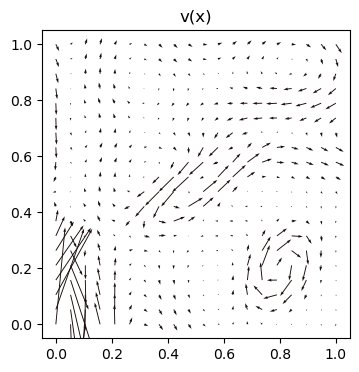

In [49]:
visualise_v_quiver(test_residual, x_test)

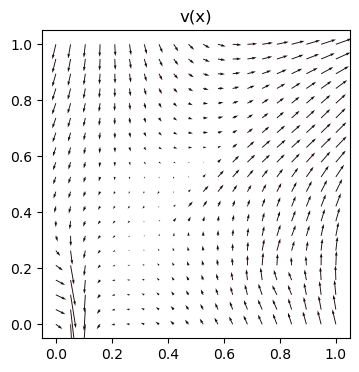

[codecarbon INFO @ 18:39:59] Energy consumed for RAM : 0.000882 kWh. RAM Power : 23.53756284713745 W
[codecarbon INFO @ 18:39:59] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:39:59] Energy consumed for all GPUs : 0.002376 kWh. Total GPU Power : 62.598719525444395 W
[codecarbon INFO @ 18:39:59] 0.004852 kWh of electricity used since the beginning.


In [ ]:
visualise_v_quiver(new_residual, x_test)

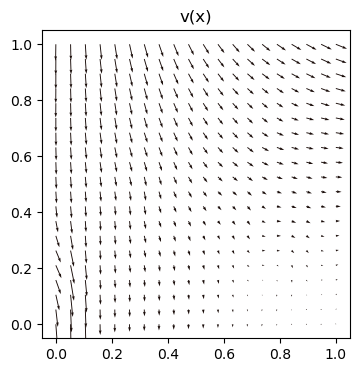

In [7]:
visualise_v_quiver(mean_pred_test, x_test)

# Log

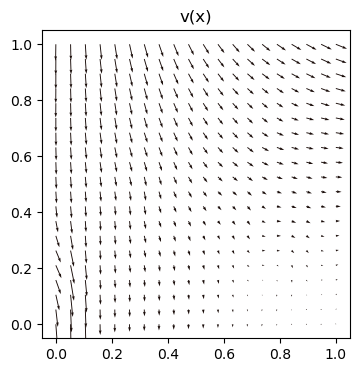

In [8]:
visualise_v_quiver(mean_pred_test, x_test)

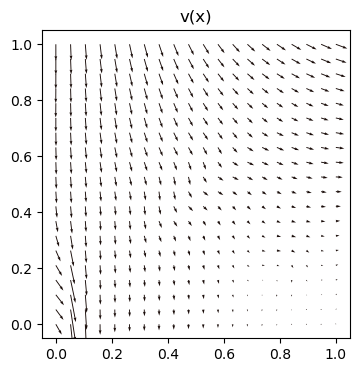

In [9]:
visualise_v_quiver(y_test, x_test)

In [10]:
y_true_flat = torch.concat([y_test[:, 0], y_test[:, 1]], dim = 0).unsqueeze(-1)  # Shape: (2 * N, 1)
y_mean_pred_flat = torch.concat([mean_pred_test[:, 0], mean_pred_test[:, 1]], dim = 0).unsqueeze(-1)  
diff = y_true_flat - y_mean_pred_flat 

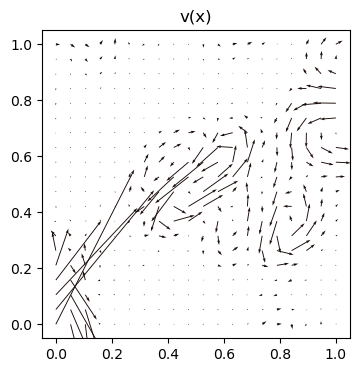

In [12]:
# vis error
visualise_v_quiver((y_test - mean_pred_test), x_test)

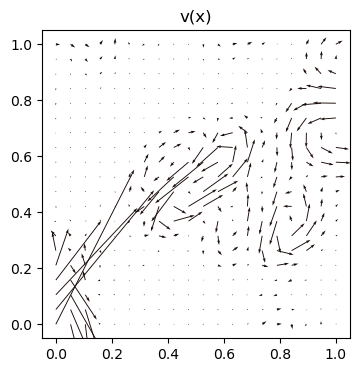

In [13]:
# 2D error for vis
error = y_test - mean_pred_test
visualise_v_quiver(error, x_test)

# Calculate NLL test

In [14]:
# Get diff
y_true_flat = torch.concat([y_test[:, 0], y_test[:, 1]], dim = 0).unsqueeze(-1)  # Shape: (2 * N, 1)
y_mean_pred_flat = torch.concat([mean_pred_test[:, 0], mean_pred_test[:, 1]], dim = 0).unsqueeze(-1)  
diff = y_true_flat - y_mean_pred_flat 

In [15]:
jitter = 1e-6  # small value to ensure numerical stability
I = torch.eye(covar_pred_test.size(0), device = covar_pred_test.device)
L = torch.linalg.cholesky(covar_pred_test + jitter * I) 

In [28]:
# Get diff
y_true_flat = torch.concat([y_test[:, 0], y_test[:, 1]], dim = 0).unsqueeze(-1)  # Shape: (2 * N, 1)
y_mean_pred_flat = torch.concat([mean_pred_test[:, 0], mean_pred_test[:, 1]], dim = 0).unsqueeze(-1)  
diff = y_true_flat - y_mean_pred_flat 

jitter = 1e-4  # small value to ensure numerical stability
I = torch.eye(covar_pred_test.size(0), device = covar_pred_test.device)
L = torch.linalg.cholesky(covar_pred_test + jitter * I) 

# This term is negative when model is very confident and variances are < 1
# Contributes positively to log likelihood if it is negative
log_det_Sigma = 2 * torch.sum(torch.log(torch.diagonal(L)))
print(f"Log det:", log_det_Sigma.item())
    
# STEP 4: Compute normalisation term
d = x_test.shape[0] * 2  # Dimensionality (since we have two outputs per point)
normalisation_term = d * torch.log(torch.tensor(2 * torch.pi, device = y_test.device))
print(f"Norm:", normalisation_term.item())

# Large values reduce the likelihood
maha = (torch.cholesky_solve(diff, L).T @ diff).squeeze()
print(f"Mahalanobis distance:", maha.item())

print(f"sum of terms", (maha + log_det_Sigma + normalisation_term).item())
log_likelihood = -0.5 * (maha + log_det_Sigma + normalisation_term)
print(f"Log likelihood:", log_likelihood.item())
print(f"NLL:", -log_likelihood.item())

Log det: -6879.04931640625
Norm: 1470.3016357421875
Mahalanobis distance: 1463.85498046875
sum of terms -3944.892578125
Log likelihood: 1972.4462890625
NLL: -1972.4462890625


In [37]:
torch.diag(covar_pred_test).shape

torch.Size([800])

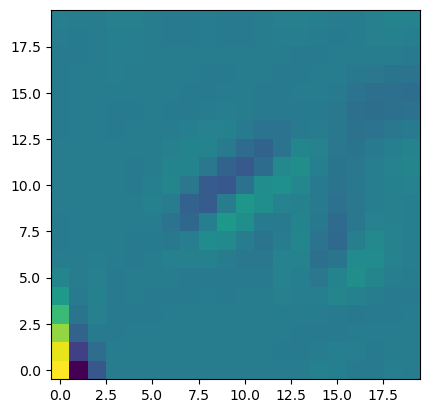

In [50]:
plt.imshow((diff[:400]+ diff[400:]).reshape(20, 20).cpu().detach().numpy(), origin = 'lower')

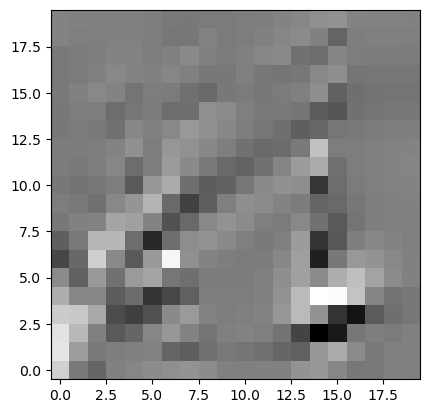

In [53]:
import matplotlib.pyplot as plt
issues = torch.mul((1/torch.diag(covar_pred_test).unsqueeze(-1)), diff)
plt.imshow((issues[:400] + issues[400:]).reshape(20, 20).cpu().detach().numpy(), cmap = 'grey', origin = 'lower')